In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import random
import time

import matplotlib.pyplot as plt

import numpy as np

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

https://github.com/facebook/fb.resnet.torch/issues/180
https://github.com/bamos/densenet.pytorch/blob/master/compute-cifar10-mean.py

In [3]:
train_transforms = transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.RandomCrop(32, padding=3),
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

In [4]:
train_data = datasets.CIFAR10('data', 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10('data', 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

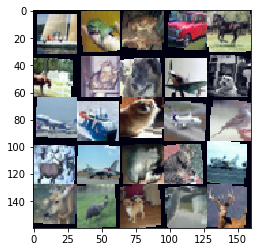

In [6]:
n_imgs = 25

batch = torch.zeros(n_imgs, 3, 32, 32)

for i in range(n_imgs):
    img, _ = train_data[i]
    batch[i] = img
        
grid_img = torchvision.utils.make_grid(batch, 
                                       nrow = 5,
                                       padding = 0,
                                       normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [8]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle = True, 
                                             batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size = BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                            batch_size = BATCH_SIZE)

In [9]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 16, 
                               kernel_size = 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        self.fc2 = nn.Linear(120, 84)
        
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        
        return x

In [10]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

In [11]:
model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 62,006 trainable parameters


In [13]:
optimizer = optim.Adam(model.parameters())

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = model.to(device)
criterion = criterion.to(device)

In [17]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [18]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [19]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 1.734 | Train Acc: 35.77%
	 Val. Loss: 1.544 |  Val. Acc: 43.04%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 1.483 | Train Acc: 46.05%
	 Val. Loss: 1.420 |  Val. Acc: 49.05%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 1.376 | Train Acc: 50.09%
	 Val. Loss: 1.313 |  Val. Acc: 52.69%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 1.301 | Train Acc: 53.03%
	 Val. Loss: 1.268 |  Val. Acc: 54.87%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 1.267 | Train Acc: 54.46%
	 Val. Loss: 1.302 |  Val. Acc: 54.73%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 1.223 | Train Acc: 56.14%
	 Val. Loss: 1.248 |  Val. Acc: 55.89%
Epoch: 07 | Epoch Time: 0m 9s
	Train Loss: 1.192 | Train Acc: 57.46%
	 Val. Loss: 1.205 |  Val. Acc: 56.39%
Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 1.173 | Train Acc: 58.16%
	 Val. Loss: 1.197 |  Val. Acc: 57.28%
Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 1.148 | Train Acc: 59.10%
	 Val. Loss: 1.201 |  Val. Acc: 57.81%
Epoch: 10 | Epoch Time: 0m 9

In [22]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.050 | Test Acc: 63.11%
